In [29]:
import pygmo as pg

from brax import envs
from brax.training import normalization

import flax
import jax
import jax.numpy as jnp
from brax.envs import create_fn

import numpy as np

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
#import numpy as np

from controllers import GruController, MlpController
from common import do_local_apg, do_one_rollout
from functools import partial

jax.config.update('jax_platform_name', 'cpu')


from IPython.display import HTML, clear_output
from brax.io import html

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))


def states_to_list(states):
    qp_flat, qp_def = jax.tree_flatten(states.qp)

    qp_list = []

    for i in range(qp_flat[0].shape[0]):
        qpc=[]
        for thing in qp_flat:
            qpc.append(thing[i,:])
        qp_list.append(jax.tree_unflatten(qp_def, qpc))
    
    return qp_list
    


len(jax.devices())

1

In [14]:
episode_length = 200
action_repeat = 1
normalize_observations=True

env_name = "inverted_double_pendulum"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, auto_reset=False)
env = env_fn()

key = jax.random.PRNGKey(0)
reset_keys = jax.random.split(key, num=jax.local_device_count())
_, model_key = jax.random.split(reset_keys[0])
noise_keys = jax.random.split(model_key, num=jax.local_device_count())

policy = GruController(env.observation_size,env.action_size,32)
normalizer_params, obs_normalizer_update_fn, obs_normalizer_apply_fn = normalization.create_observation_normalizer(
          env.observation_size, normalize_observations, num_leading_batch_dims=1)


init_states = jax.pmap(env.reset)(reset_keys)
x0 = init_states.obs
h0 = jnp.zeros(env.observation_size)

policy_params2 = policy.init(model_key, h0, x0)

In [15]:
class brax_function:
    def __init__(self, env_fn, policy, policy_params, norm_apply, norm_update, normalizer_params):
        self.env_fn = env_fn
        self.policy = policy
        self.policy_params = policy_params
                
        self.norm_update = norm_update
        self.norm_apply = norm_apply
        self.normalizer_params = normalizer_params
        
        self.key = jax.random.PRNGKey(0)
        
    def params_to_vec(self, params): 
        params_flat, _ = jax.tree_flatten(params)
        param_vec = jnp.empty(0)
        for p in params_flat:
            param_vec = jnp.concatenate([param_vec,  jnp.array(p.flatten())])
        return param_vec

    def vec_to_params(self, x):
        params_flat, params_def = jax.tree_flatten(self.policy_params)
        i = 0
        new_params_flat = []
        for p in params_flat:
            new_params_flat.append(jnp.array(x[i:i+p.size]).reshape(p.shape))
            i+=p.size
        return jax.tree_unflatten(params_def, new_params_flat)
        

    def fitness(self, x):
        params = self.vec_to_params(x)
        self.key,train_key= jax.random.split(self.key)
        
        rewards, obs, acts, states = do_one_rollout(self.env_fn, self.policy.apply, self.normalizer_params, params, self.key)
        #_, _, reward_list = do_local_apg(250, self.env_fn, self.policy.apply, self.normalizer_params, params, self.key , 1e-3, 200, 1)
        #print(reward_list[-1])
        return [-np.sum(rewards)]


    def get_bounds(self):
        param_vec = self.params_to_vec(self.policy_params)
        
        upper = jnp.ones_like(param_vec)*10.0
        lower = -upper

        return (lower.tolist(),upper.tolist())

In [16]:
fn = brax_function(env_fn, policy, policy_params2, obs_normalizer_apply_fn, obs_normalizer_update_fn, normalizer_params)

In [17]:
prob = pg.problem(fn)   

In [18]:
algo = pg.algorithm(pg.bee_colony(gen = 20, limit = 20))
pop = pg.population(prob,10)

pop = algo.evolve(pop)

print(pop.champion_f) 

[762701.75]


In [21]:
params = fn.vec_to_params(pop.champion_x)
self = fn

In [22]:
rewards, obs, acts, states = do_one_rollout(self.env_fn, self.policy.apply, self.normalizer_params, params, self.key)


-77884490.0


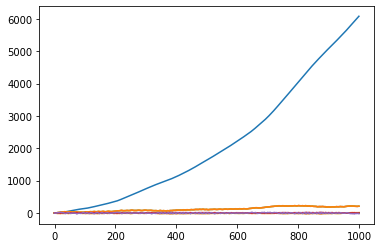

In [36]:
plt.plot(obs);
print(sum(rewards))

In [35]:
visualize(env.sys, states_to_list(states), height=400)
